In [9]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import glob
import os

from collections import defaultdict
import pprint

from torchsummary import summary

from unet.training_loop import calc_loss

In [10]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


In [45]:
model_names = glob.glob('checkpoints/simple_train_dom1_*pth')
model_names = np.sort(model_names)[1::2]
print(model_names)
model_name = model_names[0]

['checkpoints/simple_train_dom1_0.85pth'
 'checkpoints/simple_train_dom1_0.89pth'
 'checkpoints/simple_train_dom1_0.93pth'
 'checkpoints/simple_train_dom1_0.97pth']


In [46]:
model = torch.load(model_name)
model = model.to(device)
model.eval()

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [47]:
summary(model, input_size=(1, 256, 256))

RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)

#### Training/Testing Domains

**Training Dom 1:** 

Only circles with the following noise parameters  
center_extent = (64, 192)  
radius_extent = 64  
sigma_range = [0.04, 0.06]  

---

**Testing Dom 1:** 

Only circles with the following noise parameters  
center_extent = (64, 192)  
radius_extent = 64  
sigma_range = [0.04, 0.06]  

---


**Testing Dom 2:** 

Only rectangles with the following noise parameters  
start = (64, 192)  
extent = 64  
sigma_range = [0.04, 0.06]  

---


**Testing Dom 3:** 

Only circles with the following noise parameters  
center_extent = (64, 192)  
radius_extent = 64  
sigma_range = [0.08, 0.12]  

---


In [48]:
def inferOnDomain(dataPath, isMetrics=True, isPlot=True, n_channels=2):
    d = np.load(dataPath)
    x, y = d['x'], d['y']
#     x.shape, y.shape
    
    #shuffle x and y
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    
    offset = 24
    x, y  = x[:offset], y[:offset]

    if n_channels == 1:
        yNot = np.logical_not(y)
        y = np.concatenate([y, yNot], axis = 1)

    x = torch.as_tensor(x, dtype = torch.float)
    x = x.to(device=device)
    
    y_pred = model(x)
    y_pred = y_pred.cpu().detach().numpy()
    y_bin = (y_pred>0.5)*1.0

#     y_pred = (y_pred>0.7)*1.0
    x = x.cpu().detach().numpy()

    if isPlot:
        plt.figure(figsize = (10,40))
        for i in range(offset):
            plt.subplot(offset, 3, i*3+1)
            plt.imshow(x[i,0, :,:], cmap = 'gray')
            
            plt.subplot(offset, 3, i*3+2)
#             plt.imshow(y_bin[i,0, :,:], cmap = 'gray')
            pred = y_bin[i]
            pred = np.transpose(pred, (1,2,0))
            zero_arr = np.zeros_like(pred)
            pred = np.concatenate((pred, zero_arr[:,:,:1]), axis = -1)
            plt.imshow(pred)

            plt.subplot(offset, 3, i*3+3)
#             plt.imshow(y[i,0, :,:], cmap = 'gray')
            gt = y[i]*255
            gt = np.transpose(gt, (1,2,0))
            zero_arr = np.zeros_like(gt)
            gt = np.concatenate((gt, zero_arr[:,:,:1]), axis = -1)
            plt.imshow(gt)
#             plt.imshow(y[i,0, :,:] + y[i,1, :,:])

        


    if isMetrics:
        metrics = defaultdict(float)
        print(y.shape, y_pred.shape)
        y = torch.as_tensor(y, dtype= torch.float)
        y_pred = torch.as_tensor(y_pred, dtype = torch.float)
        loss = calc_loss(y_pred, y, metrics)
        for k in metrics.keys():
            print("{}: {}".format(k, metrics[k]/offset))

In [49]:
def inferOnDomainByGroups(dataPath, isMetrics=True, isPlot=True, n_channels=2):
    d = np.load(dataPath)
    x, y = d['x'], d['y']
#     x.shape, y.shape
    n_train = len(x)
    #shuffle x and y
#     indices = np.arange(len(x))
#     np.random.shuffle(indices)
#     x = x[indices]
#     y = y[indices]
    offset = 8
    allMetrics = []
    for j, i in enumerate([0, n_train//4, n_train//2, int(0.75*n_train)]):
        x_test, y_test = x[i:i +offset], y[i:i+offset]
#         print(x_test.shape, y_test.shape)

        x_test = torch.as_tensor(x_test, dtype = torch.float)
        x_test = x_test.to(device=device)

        y_pred = model(x_test)
        y_pred = y_pred.cpu().detach().numpy()
        y_bin = (y_pred>0.5)*1.0


        x_test = x_test.cpu().detach().numpy()

        if isPlot:
            plt.figure(figsize = (10,40))
            for i in range(offset):
                plt.subplot(offset, 3, i*3+1)
                plt.imshow(x_test[i,0, :,:], cmap = 'gray')

                plt.subplot(offset, 3, i*3+2)
    #             plt.imshow(y_bin[i,0, :,:], cmap = 'gray')
                pred = y_bin[i]
                pred = np.transpose(pred, (1,2,0))
                zero_arr = np.zeros_like(pred)
                pred = np.concatenate((pred, zero_arr[:,:,:1]), axis = -1)
                plt.imshow(pred)

                plt.subplot(offset, 3, i*3+3)
    #             plt.imshow(y[i,0, :,:], cmap = 'gray')
                gt = y_test[i]*255
                gt = np.transpose(gt, (1,2,0))
                zero_arr = np.zeros_like(gt)
                gt = np.concatenate((gt, zero_arr[:,:,:1]), axis = -1)
                plt.imshow(gt)
    #             plt.imshow(y[i,0, :,:] + y[i,1, :,:])
    
        
        print("************Group ", j, "************")

        if isMetrics:
            metrics = defaultdict(float)
            print(y_test.shape, y_pred.shape)
            y_test = torch.as_tensor(y_test, dtype= torch.float)
            y_pred = torch.as_tensor(y_pred, dtype = torch.float)
            loss = calc_loss(y_pred, y_test, metrics)
            for k in metrics.keys():
                print("{}: {}".format(k, metrics[k]/offset))
            allMetrics.append(metrics)
    return allMetrics

************Group  0 ************
(8, 2, 256, 256) (8, 2, 256, 256)
bce: 0.0050424328073859215
dice: 0.008380454033613205
loss: 0.006711443420499563
************Group  1 ************
(8, 2, 256, 256) (8, 2, 256, 256)
bce: 0.011231321841478348
dice: 0.06355884671211243
loss: 0.03739508241415024
************Group  2 ************
(8, 2, 256, 256) (8, 2, 256, 256)
bce: 0.0026755277067422867
dice: 0.005494371056556702
loss: 0.004084949381649494
************Group  3 ************
(8, 2, 256, 256) (8, 2, 256, 256)
bce: 0.0026442359667271376
dice: 0.0038198865950107574
loss: 0.0032320613972842693


[defaultdict(float,
             {'bce': 0.04033946245908737,
              'dice': 0.06704363226890564,
              'loss': 0.053691547363996506}),
 defaultdict(float,
             {'bce': 0.08985057473182678,
              'dice': 0.5084707736968994,
              'loss': 0.2991606593132019}),
 defaultdict(float,
             {'bce': 0.021404221653938293,
              'dice': 0.04395496845245361,
              'loss': 0.03267959505319595}),
 defaultdict(float,
             {'bce': 0.0211538877338171,
              'dice': 0.03055909276008606,
              'loss': 0.025856491178274155})]

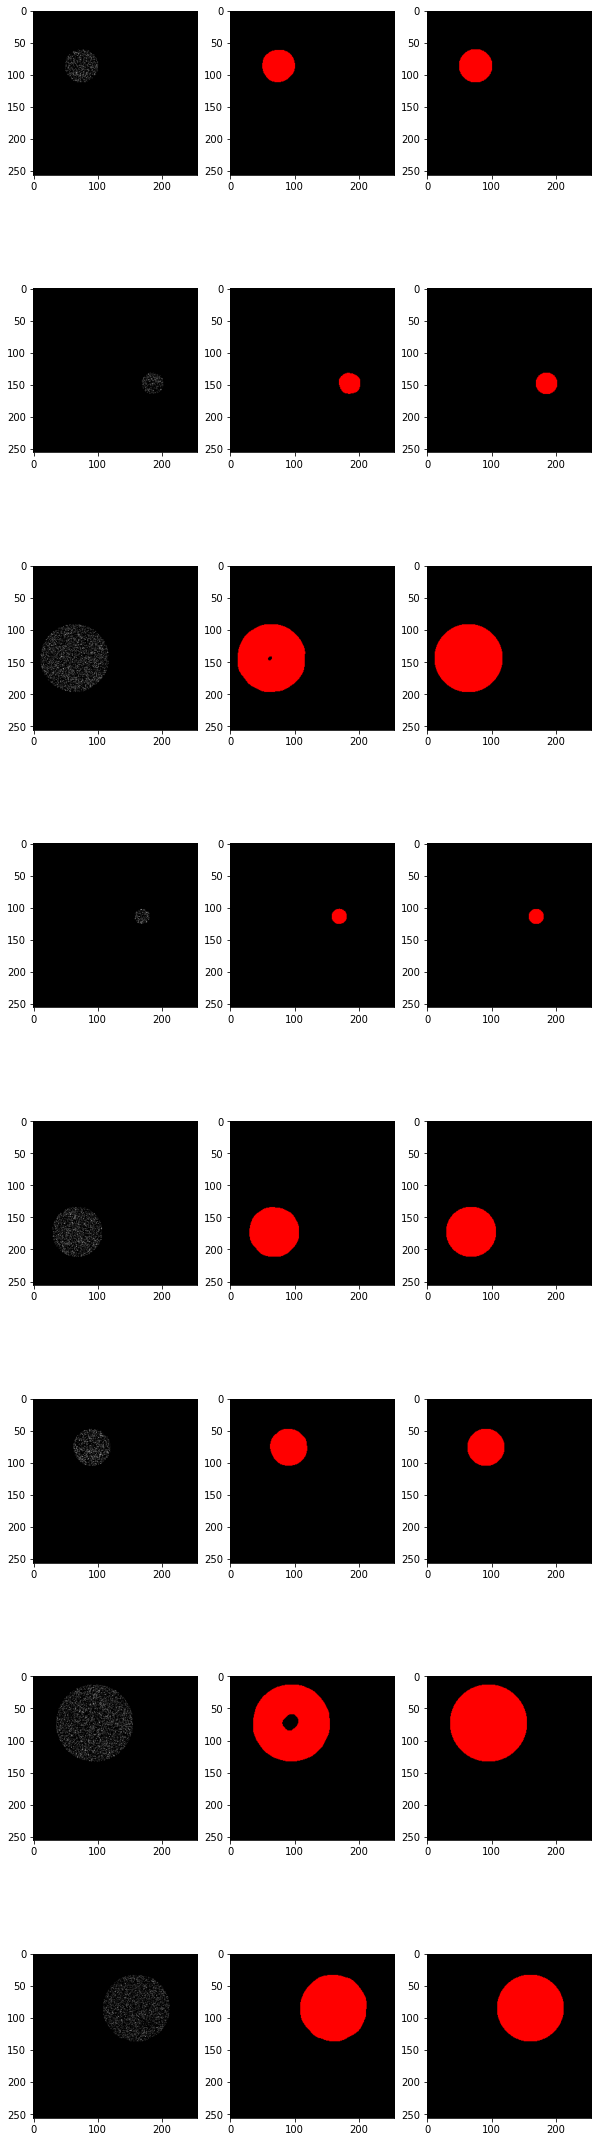

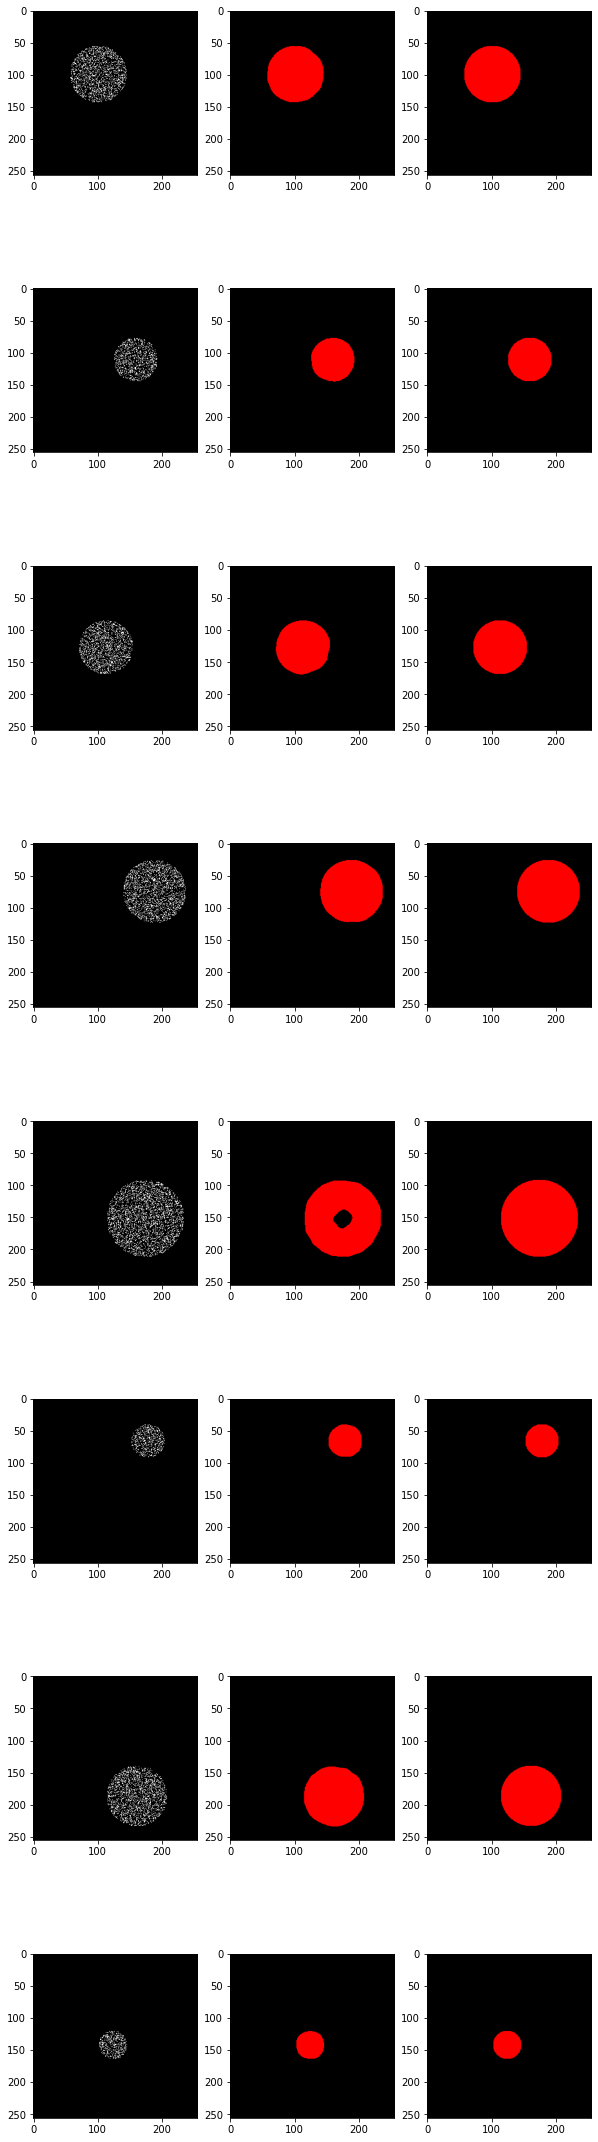

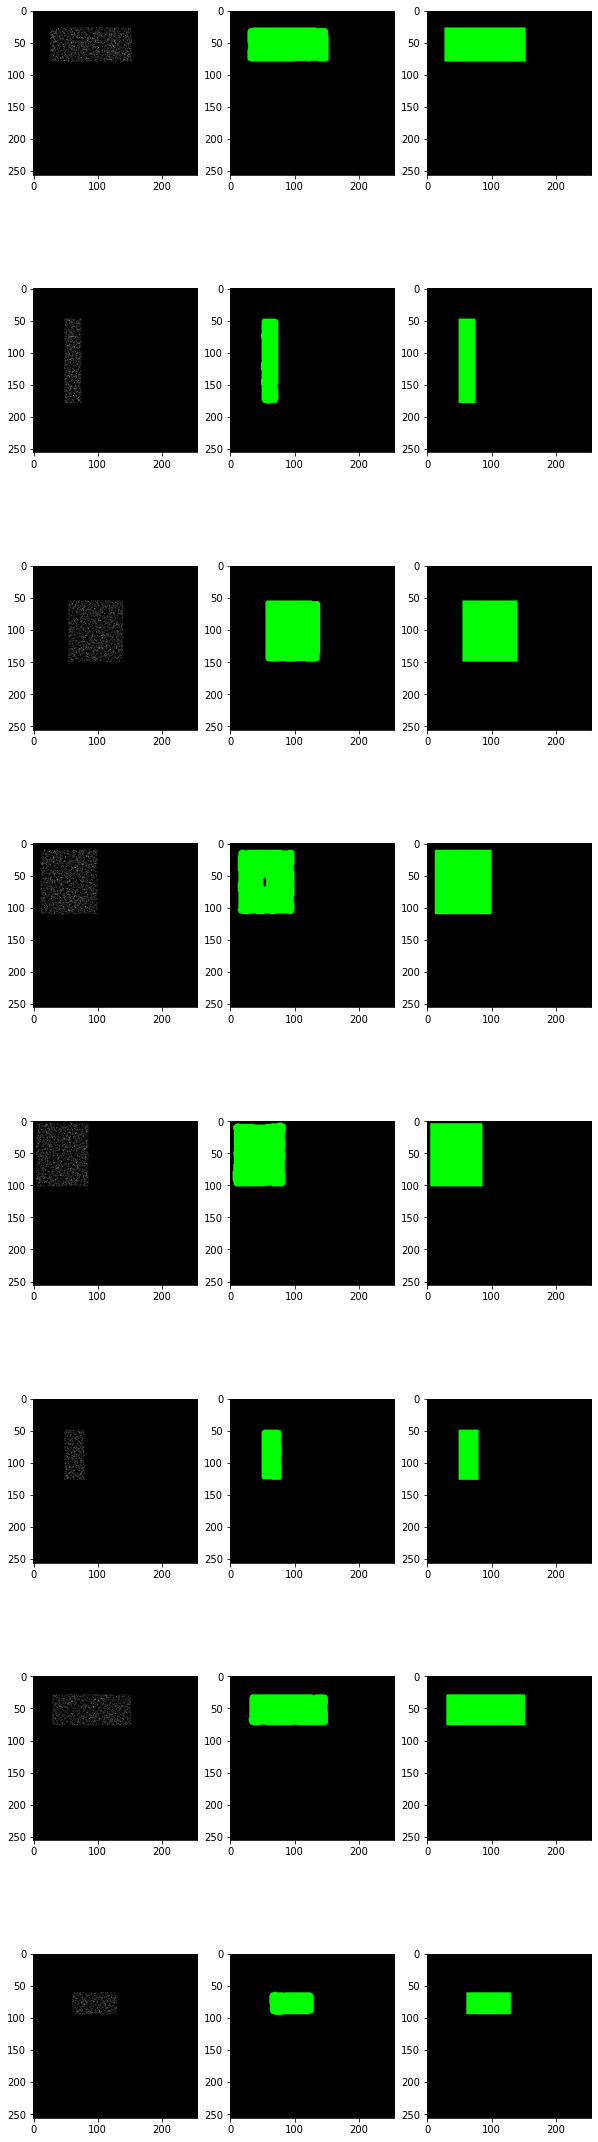

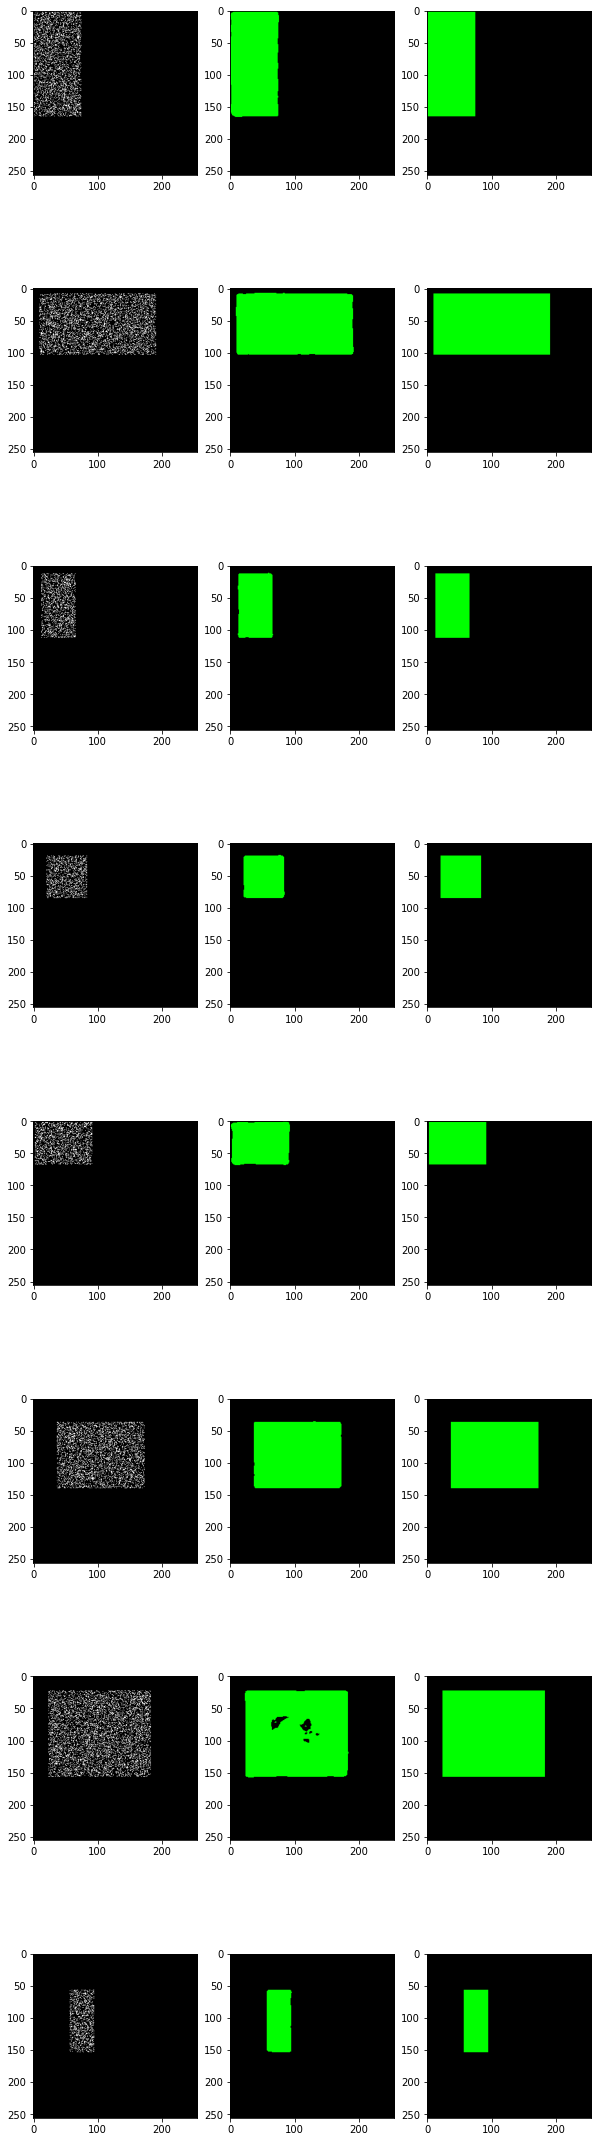

In [50]:
#Load test domain 1
data_path = 'data/syntheticSegmentation/simple_balanced_test_dom1.npz'

inferOnDomainByGroups(data_path)

In [51]:
model_names = glob.glob('checkpoints/simple_train_dom1_*pth')
model_names = np.sort(model_names)[1::2]
print(model_names)
offset = 8

data_path = 'data/syntheticSegmentation/simple_balanced_test_dom1.npz'

metrics_list = []

for model_name in model_names:
    model = torch.load(model_name)
    model = model.to(device)
    model.eval()
    
    print("*************%s******************+"%(model_name))
    allMetrics = inferOnDomainByGroups(data_path, isPlot = False)
    metrics = allMetrics[1]
    dice = 1 - metrics['dice']/offset
    metrics_list.append(dice)

['checkpoints/simple_train_dom1_0.85pth'
 'checkpoints/simple_train_dom1_0.89pth'
 'checkpoints/simple_train_dom1_0.93pth'
 'checkpoints/simple_train_dom1_0.97pth']
*************checkpoints/simple_train_dom1_0.85pth******************+
************Group  0 ************
(8, 2, 256, 256) (8, 2, 256, 256)
bce: 0.0050424328073859215
dice: 0.008380454033613205
loss: 0.006711443420499563
************Group  1 ************
(8, 2, 256, 256) (8, 2, 256, 256)
bce: 0.011231321841478348
dice: 0.06355884671211243
loss: 0.03739508241415024
************Group  2 ************
(8, 2, 256, 256) (8, 2, 256, 256)
bce: 0.0026755277067422867
dice: 0.005494371056556702
loss: 0.004084949381649494
************Group  3 ************
(8, 2, 256, 256) (8, 2, 256, 256)
bce: 0.0026442359667271376
dice: 0.0038198865950107574
loss: 0.0032320613972842693
*************checkpoints/simple_train_dom1_0.89pth******************+
************Group  0 ************
(8, 2, 256, 256) (8, 2, 256, 256)
bce: 0.0027643071953207254
dice:

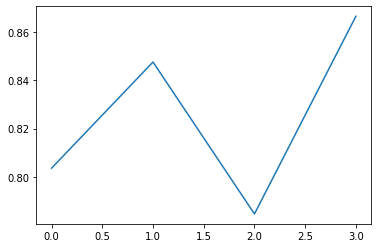

In [25]:
plt.plot(metrics_list)

simple_train_dom1_0.93.npz
(24, 2, 256, 256) (24, 2, 256, 256)
bce: 0.0032408263068646193
dice: 0.024121589958667755
loss: 0.013681207783520222


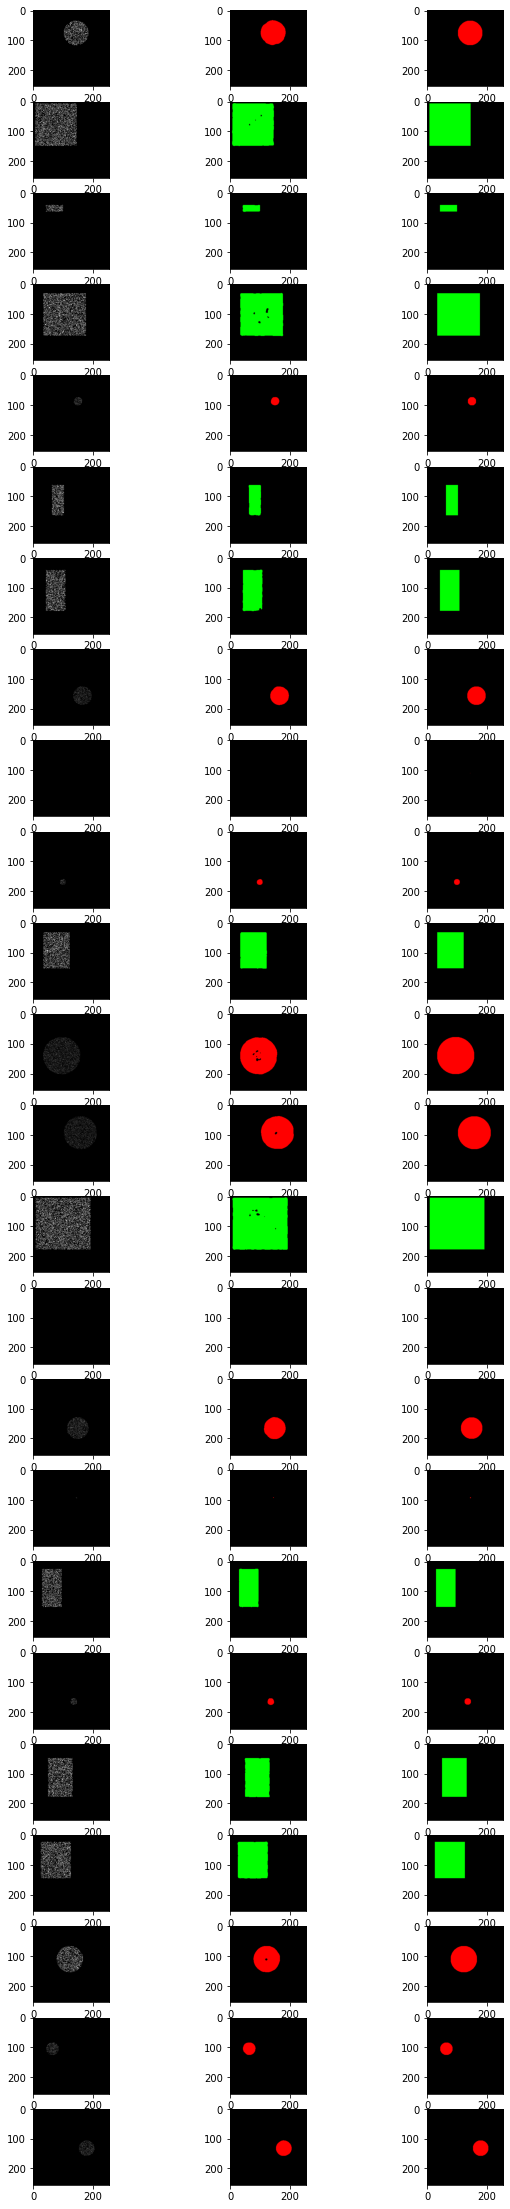

In [75]:
#Load train domain 1

dataPath = os.path.join('data/syntheticSegmentation', os.path.basename(model_name[:-len('pth')] + '.npz'))
print(os.path.basename(model_name[:-len('pth')] + '.npz'))
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 0.03338749706745148
dice: 0.06165092810988426
loss: 0.04751921445131302


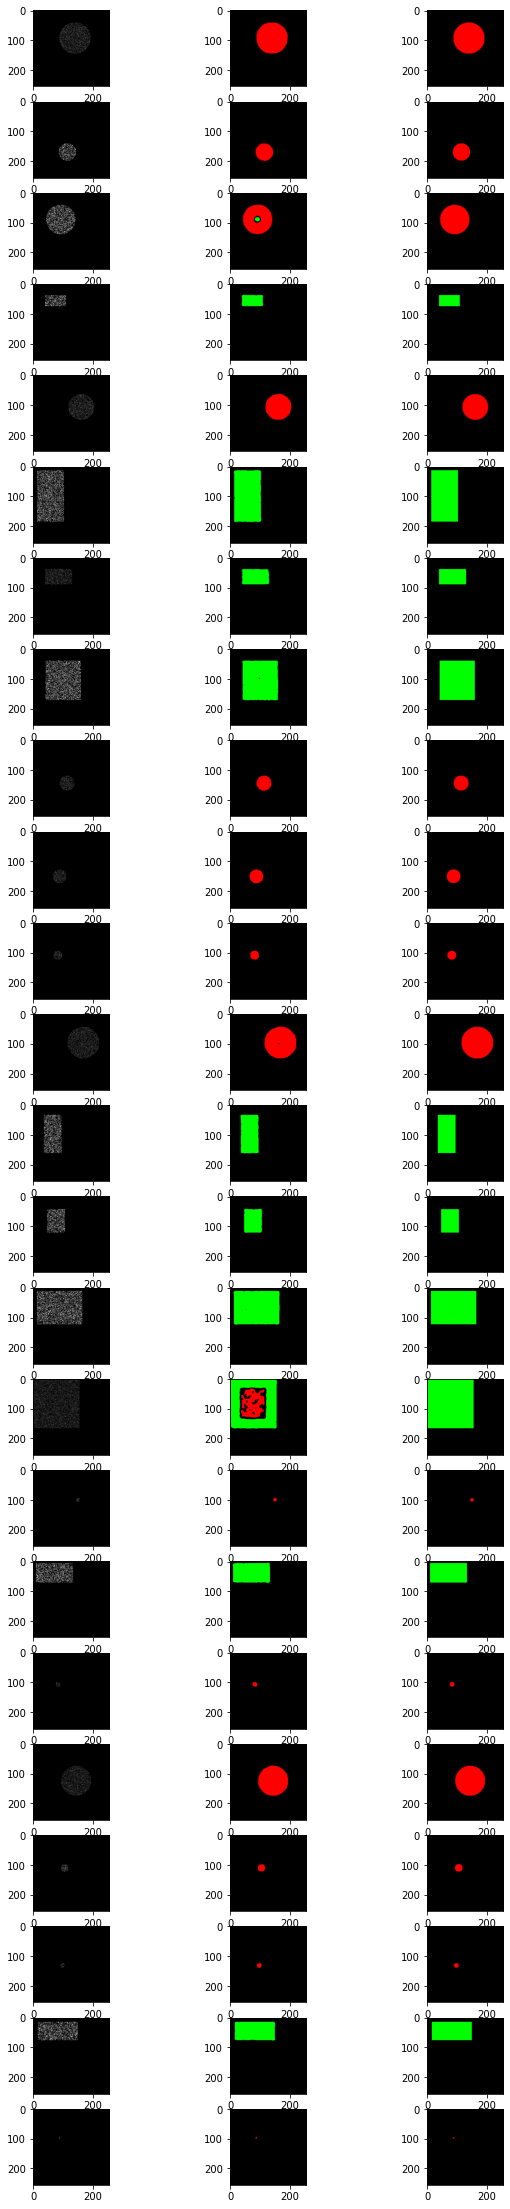

In [76]:
#Load test domain 1
data_path = 'data/syntheticSegmentation//simple_test_dom1_*'
test_datasets = glob.glob(data_path)
test_dataset = test_datasets[0]
inferOnDomain(test_dataset)

In [79]:
#Load test domain 1
data_path = 'data/syntheticSegmentation/simple_balanced_test_dom1.npz'

inferOnDomainByGroups(test_dataset)

RuntimeError: CUDA error: invalid configuration argument

TypeError: Invalid shape (256, 256, 2) for image data

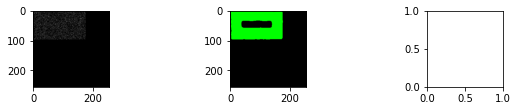

In [68]:
#Load test domain 2
dataPath = 'data/syntheticSegmentation/test_dom2.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 2.3020946979522705
dice: 0.5235863924026489
loss: 1.4128406047821045


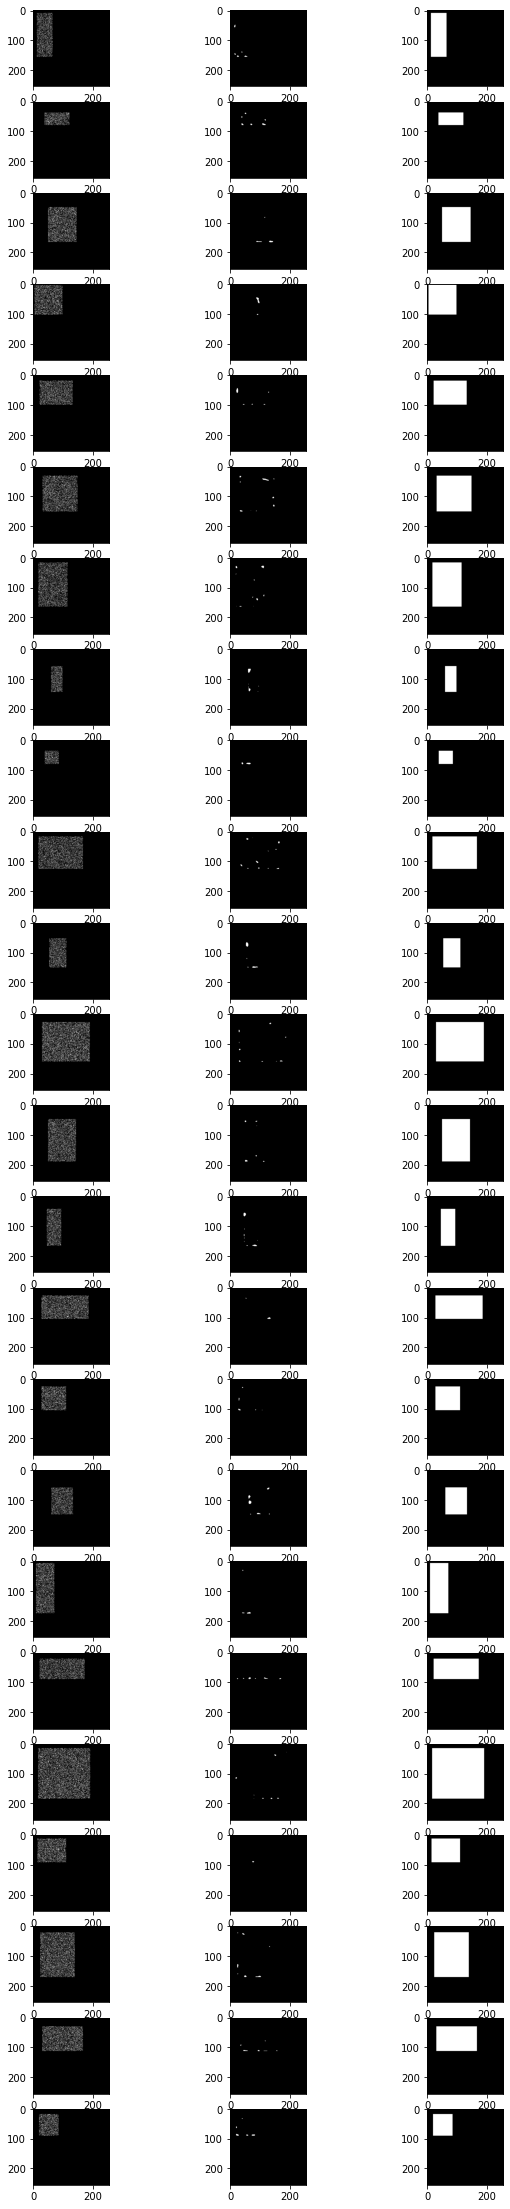

In [32]:
#Load test domain 7
dataPath = 'data/syntheticSegmentation/test_dom7.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 4.181568145751953
dice: 0.45053645968437195
loss: 2.316052198410034


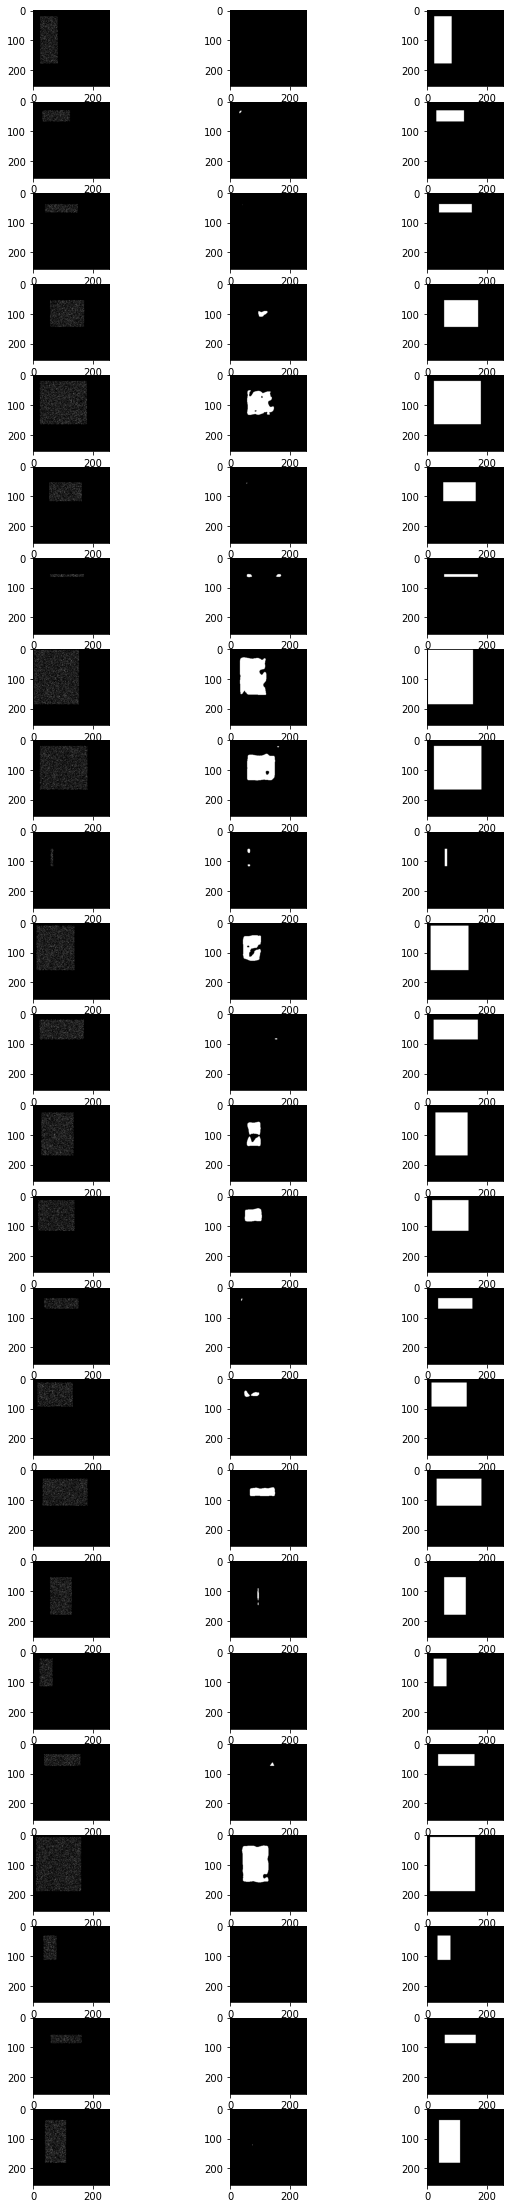

In [37]:
#Load test domain 8
dataPath = 'data/syntheticSegmentation/test_dom8.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 0.008452002890408039
dice: 0.03981083258986473
loss: 0.024131417274475098


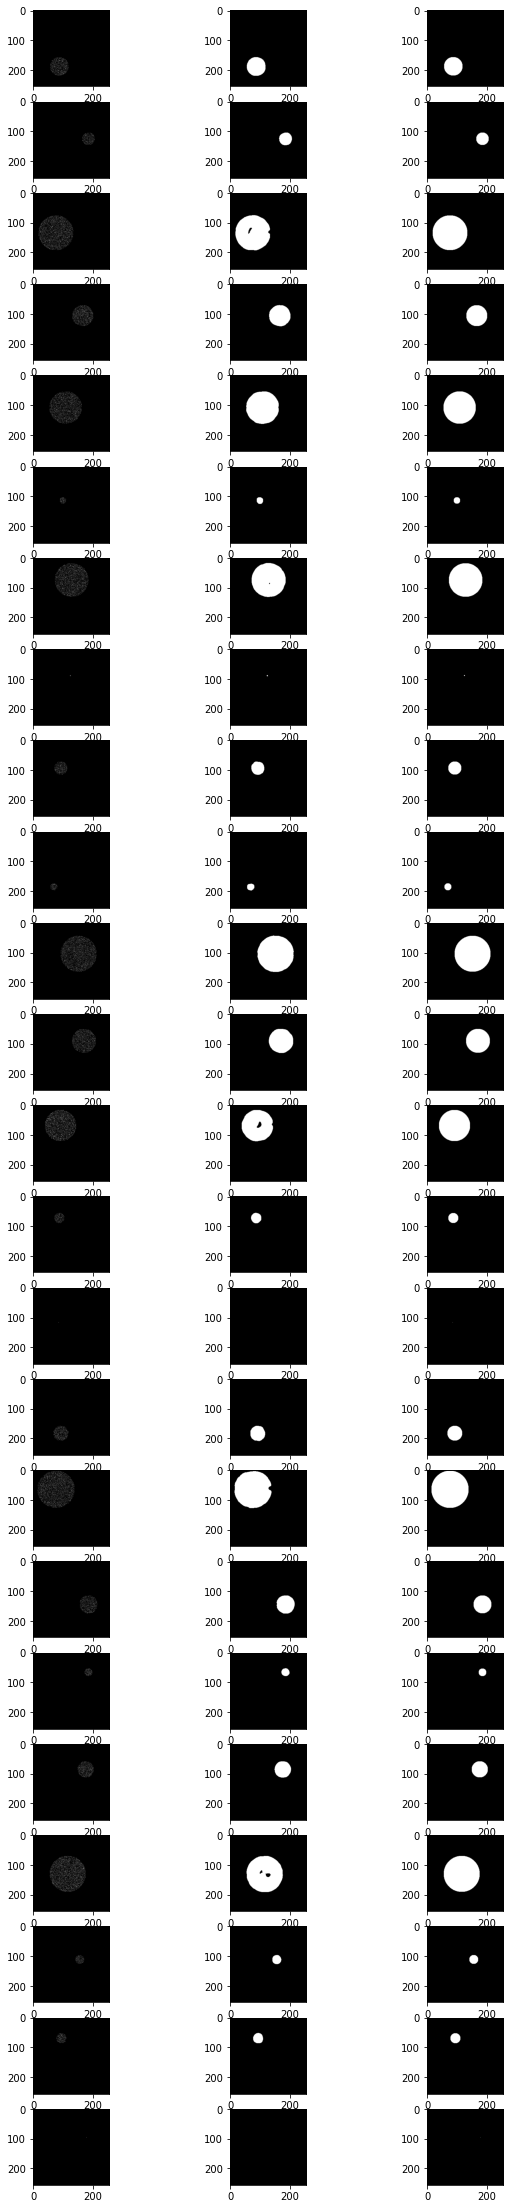

In [35]:
#Load test domain 3
dataPath = 'data/syntheticSegmentation/test_dom3.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 0.4437408745288849
dice: 0.2887401878833771
loss: 0.366240531206131


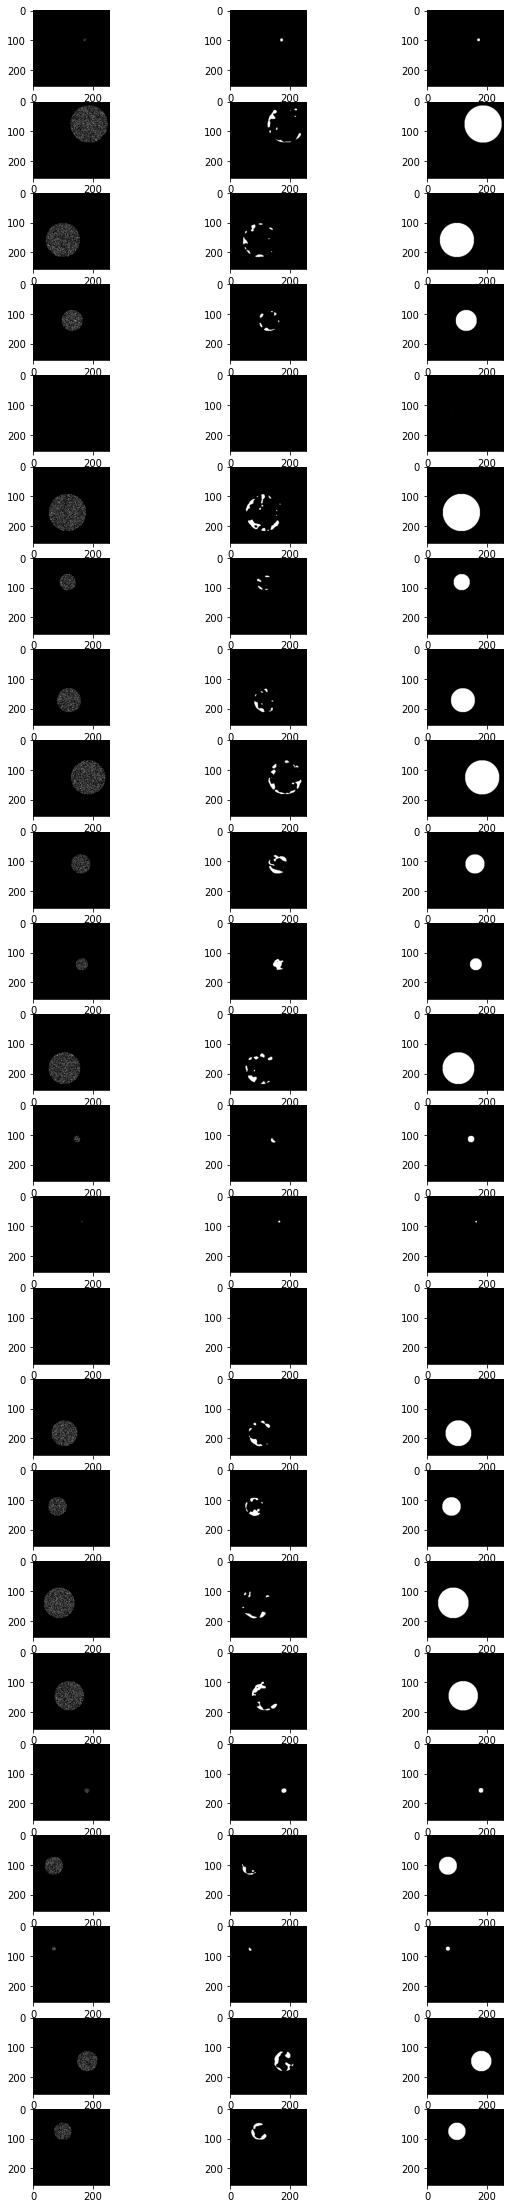

In [34]:
#Load test domain 4
dataPath = 'data/syntheticSegmentation/test_dom4.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 13.99227237701416
dice: 0.49389132857322693
loss: 7.243082046508789


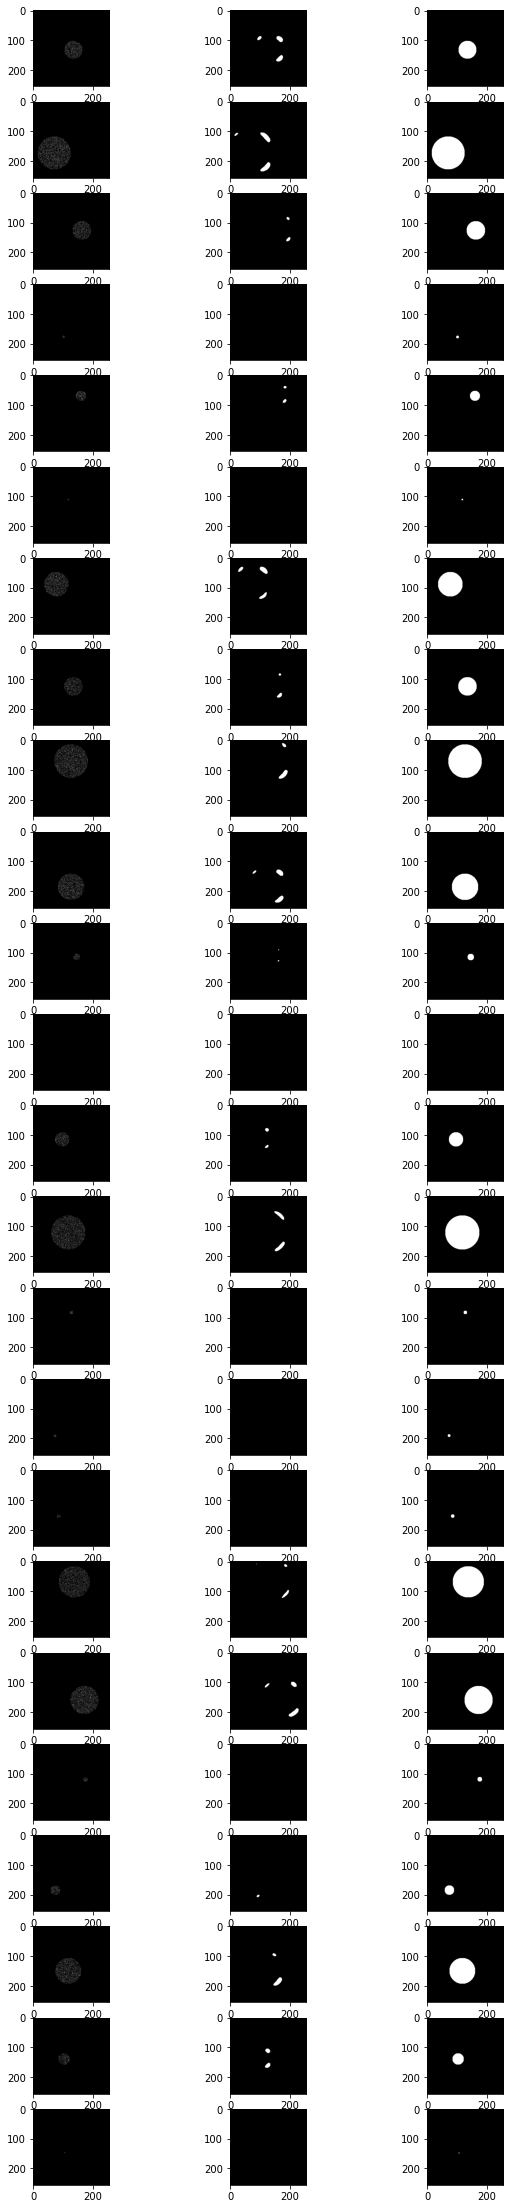

In [33]:
#Load test domain 5
dataPath = 'data/syntheticSegmentation/test_dom5.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 60.91597366333008
dice: 0.946617603302002
loss: 30.93129539489746


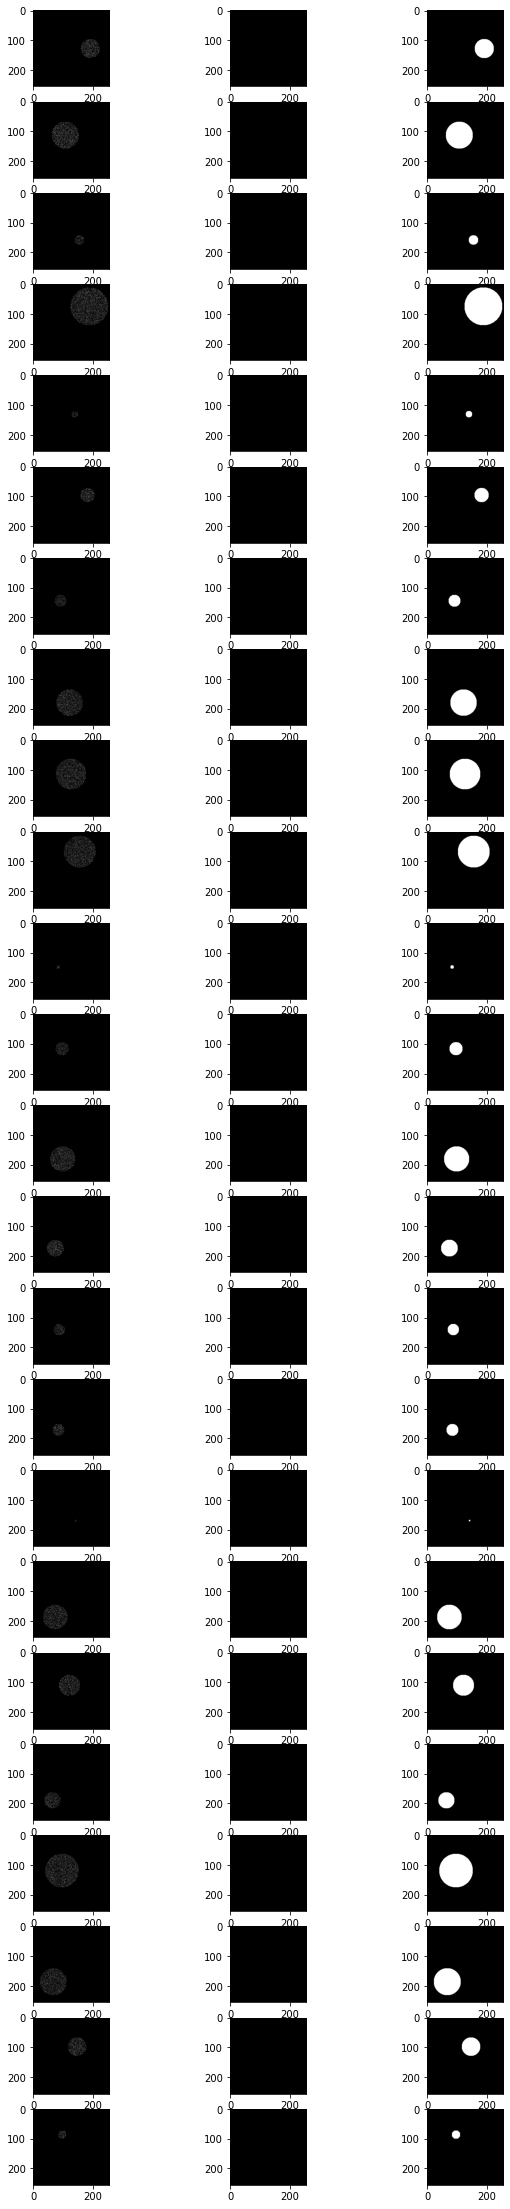

In [28]:
#Load test domain 6
dataPath = 'data/syntheticSegmentation/test_dom6.npz'
inferOnDomain(dataPath)

In [14]:
data = np.load("data/syntheticSegmentation/test_dom2.npz")
im, mask = data['x'], data['y']
im.shape, mask.shape

((256, 1, 256, 256), (256, 1, 256, 256))

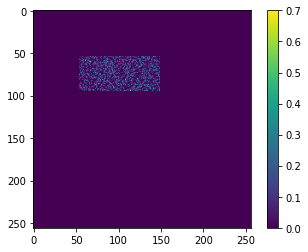

In [15]:
plt.imshow(im[7,0])
plt.colorbar()